In [10]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Optional, List, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from dotenv import load_dotenv
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

In [3]:
load_dotenv()

True

In [6]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=os.getenv("GOOGLE_API_KEY"),
    temperature=0.1
)

In [19]:
class SQLWorkflowState(TypedDict):
    user_question: str
    generated_sql: Optional[str]
    sql_validation_error: Optional[str]
    query_results: Optional[List[Dict[str, Any]]]
    final_response: Optional[str]
    error_message: Optional[str]
    database_schema: Optional[str]

In [ ]:
# Import the database schema function
from database_setup import get_schema_description

In [17]:
def sql_generator_node(state: SQLWorkflowState) -> SQLWorkflowState:
    user_question = state["user_question"]
    
    # Get database schema if not already in state
    if not state.get("database_schema"):
        try: 
            schema = get_schema_description()
            state["database_schema"] = schema
        except Exception as e:
            state["generated_sql"] = f"Error fetching schema: {str(e)}"
            return state

    sql_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert SQL developer. Convert natural language questions to SQL queries.

Database Schema:
{schema}

Rules:
1. Generate ONLY the SQL query, no explanations
2. Use proper SQL syntax for SQLite
3. Always use SELECT statements unless explicitly asked for modifications
4. Use proper table joins when needed
5. Include appropriate WHERE clauses, GROUP BY, ORDER BY as needed
6. Ensure column names and table names match the schema exactly
7. Use proper aggregation functions (COUNT, SUM, AVG, etc.) when appropriate

Example:
Question: "What are the top 5 selling products?"
SQL: SELECT p.product_name, SUM(s.quantity) as total_sold FROM products p JOIN sales s ON p.product_id = s.product_id GROUP BY p.product_id, p.product_name ORDER BY total_sold DESC LIMIT 5;

Now generate SQL for the following question:"""),
        ("human", "{question}")
    ])

    try: 
        chain = sql_prompt | model
        response = chain.invoke({
            "schema": state["database_schema"],
            "question": user_question
        })
        sql_query = response.content.strip()

        # Clean up the SQL (remove code blocks if present)
        if sql_query.startswith("```"):
            sql_query = sql_query.split("```")[1]
            if sql_query.startswith("sql"):
                sql_query = sql_query[3:]

        sql_query = sql_query.strip()
        state["generated_sql"] = sql_query

    except Exception as e:
        state["generated_sql"] = f"Error generating SQL: {str(e)}"

    return state

In [20]:
def query_validator_node(state: SQLWorkflowState) -> SQLWorkflowState:
    """
    Node that validates SQL queries for safety and syntax
    """
    if state.get("error_message"):
        return state
    
    sql_query = state.get("generated_sql", "").upper()
    
    # Check for destructive operations
    destructive_keywords = [
        "DROP", "DELETE", "UPDATE", "INSERT", "ALTER", "CREATE", 
        "TRUNCATE", "REPLACE", "PRAGMA", "ATTACH", "DETACH"
    ]
    
    for keyword in destructive_keywords:
        if keyword in sql_query:
            state["sql_validation_error"] = f"Query contains potentially destructive operation: {keyword}"
            return state
    
    # Basic syntax validation using SQLite's EXPLAIN
    try:
        conn = sqlite3.connect(str(DB_PATH))
        cursor = conn.cursor()
        
        # Try to explain the query to validate syntax
        cursor.execute(f"EXPLAIN QUERY PLAN {state['generated_sql']}")
        cursor.fetchall()
        
        conn.close()
        
        # If we get here, the query is valid
        state["sql_validation_error"] = None
        
    except sqlite3.Error as e:
        state["sql_validation_error"] = f"SQL syntax error: {str(e)}"
        conn.close()
    except Exception as e:
        state["sql_validation_error"] = f"Validation error: {str(e)}"
    
    return state

In [21]:
def query_executor_node(state: SQLWorkflowState) -> SQLWorkflowState:
    """
    Node that executes validated SQL queries
    """
    if state.get("error_message") or state.get("sql_validation_error"):
        return state
    
    try:
        conn = sqlite3.connect(str(DB_PATH))
        conn.row_factory = sqlite3.Row  # Enable column access by name
        cursor = conn.cursor()
        
        # Execute the query
        cursor.execute(state["generated_sql"])
        rows = cursor.fetchall()
        
        # Convert rows to list of dictionaries
        results = [dict(row) for row in rows]
        state["query_results"] = results
        
        conn.close()
        
    except sqlite3.Error as e:
        state["error_message"] = f"Database execution error: {str(e)}"
    except Exception as e:
        state["error_message"] = f"Query execution error: {str(e)}"
    
    return state

In [22]:
def response_explainer_node(state: SQLWorkflowState) -> SQLWorkflowState:
    """
    Node that explains query results in natural language
    """
    if state.get("error_message") or state.get("sql_validation_error"):
        # Handle error cases
        if state.get("sql_validation_error"):
            state["final_response"] = f"I couldn't execute your query because: {state['sql_validation_error']}. Please rephrase your question."
        else:
            state["final_response"] = f"I encountered an error: {state['error_message']}. Please try again with a different question."
        return state
    
    user_question = state["user_question"]
    sql_query = state["generated_sql"]
    results = state["query_results"]
    
    # Create the prompt for response explanation
    explanation_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful data analyst. Explain SQL query results in clear, natural language.

Guidelines:
1. Start by acknowledging the user's question
2. Provide a clear, concise summary of the findings
3. Include the most important data points from the results
4. If there are many results, summarize the key insights
5. Use natural language, not technical jargon
6. If no results were found, explain that clearly
7. Be conversational and helpful

Format your response to be informative but easy to understand."""),
        ("human", """User Question: {question}

SQL Query Used: {sql_query}

Query Results: {results}

Please explain these results in natural language:""")
    ])
    
    try:
        # Prepare results for explanation
        if not results:
            results_text = "No results found"
        else:
            # Limit results shown to LLM to avoid token limits
            display_results = results[:10] if len(results) > 10 else results
            results_text = str(display_results)
            if len(results) > 10:
                results_text += f"\n... and {len(results) - 10} more results"
        
        # Generate explanation using the LLM
        chain = explanation_prompt | model
        response = chain.invoke({
            "question": user_question,
            "sql_query": sql_query,
            "results": results_text
        })
        
        state["final_response"] = response.content.strip()
        
    except Exception as e:
        state["final_response"] = f"I found {len(results)} results for your question, but couldn't generate a detailed explanation. Error: {str(e)}"
    
    return state

In [23]:
graph = StateGraph(SQLWorkflowState)

graph.add_node("sql_generator", sql_generator_node)
graph.add_node("query_validator", query_validator_node)
graph.add_node("query_executor", query_executor_node)
graph.add_node("response_explainer", response_explainer_node)

graph.add_edge(START, "sql_generator")
graph.add_edge("sql_generator", "query_validator")
graph.add_edge("query_validator", "query_executor")
graph.add_edge("query_executor", "response_explainer")
graph.add_edge("response_explainer", END)

app = graph.compile()


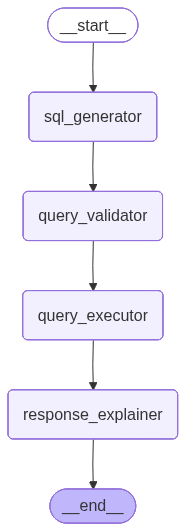

In [24]:
app